In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score, roc_curve, auc
from sklearn.model_selection import KFold
import cv2

In [7]:
train_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/train"
test_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/test"

img_height, img_width = 224, 224
batch_size = 32
num_classes = 7  # <-- Update as per your dataset


In [8]:
import os

train_dir = "D:/mca/4th sem/major pj/DATASET'S/combined/train"

# Check if the directory exists
if not os.path.exists(train_dir):
    print(f"Directory does not exist: {train_dir}")
else:
    # List all subfolders (classes)
    class_names = [name for name in os.listdir(train_dir)
                   if os.path.isdir(os.path.join(train_dir, name))]
    print("Classes found in the training directory:")
    for idx, class_name in enumerate(class_names):
        print(f"{idx+1}. {class_name}")


Classes found in the training directory:
1. angry
2. disgust
3. fear
4. happy
5. neutral
6. sad
7. surprise


In [3]:
# Data augmentation (stronger)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    validation_split=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)


Found 46026 images belonging to 7 classes.
Found 11503 images belonging to 7 classes.
Found 14244 images belonging to 7 classes.


In [4]:
# Model with batch normalization and L2 regularization
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_mobilenet_fer_fine.h5', save_best_only=True, monitor='val_loss')
]

# Train (transfer learning)
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/50
1439/1439 [==============================] - 1132s 784ms/step - loss: 2.6994 - accuracy: 0.2958 - val_loss: 1.8801 - val_accuracy: 0.3649 - lr: 0.0010


C:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
1439/1439 [==============================] - 890s 618ms/step - loss: 1.8854 - accuracy: 0.3276 - val_loss: 1.8183 - val_accuracy: 0.3674 - lr: 0.0010
Epoch 3/50
1439/1439 [==============================] - 890s 618ms/step - loss: 1.8725 - accuracy: 0.3272 - val_loss: 1.8138 - val_accuracy: 0.3716 - lr: 0.0010
Epoch 4/50
1439/1439 [==============================] - 893s 621ms/step - loss: 1.8740 - accuracy: 0.3263 - val_loss: 1.8343 - val_accuracy: 0.3449 - lr: 0.0010
Epoch 5/50
1439/1439 [==============================] - 893s 621ms/step - loss: 1.8664 - accuracy: 0.3286 - val_loss: 1.7887 - val_accuracy: 0.3698 - lr: 0.0010
Epoch 6/50
1439/1439 [==============================] - 893s 620ms/step - loss: 1.8585 - accuracy: 0.3289 - val_loss: 1.9206 - val_accuracy: 0.3132 - lr: 0.0010
Epoch 7/50
1439/1439 [==============================] - 894s 621ms/step - loss: 1.8493 - accuracy: 0.3315 - val_loss: 1.8278 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 8/50
1439/1439 [============

In [6]:
# Fine-tuning: unfreeze more layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Unfreeze last 50 layers
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/40
1439/1439 [==============================] - 1127s 779ms/step - loss: 1.4382 - accuracy: 0.4604 - val_loss: 1.2441 - val_accuracy: 0.5326 - lr: 1.0000e-04
Epoch 2/40
1439/1439 [==============================] - 1115s 775ms/step - loss: 1.2685 - accuracy: 0.5297 - val_loss: 1.1840 - val_accuracy: 0.5612 - lr: 1.0000e-04
Epoch 3/40
1439/1439 [==============================] - 1116s 775ms/step - loss: 1.1955 - accuracy: 0.5617 - val_loss: 1.1100 - val_accuracy: 0.5956 - lr: 1.0000e-04
Epoch 4/40
1439/1439 [==============================] - 1112s 773ms/step - loss: 1.1457 - accuracy: 0.5798 - val_loss: 1.0149 - val_accuracy: 0.6224 - lr: 1.0000e-04
Epoch 5/40
1439/1439 [==============================] - 1131s 786ms/step - loss: 1.1092 - accuracy: 0.5923 - val_loss: 0.9818 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 6/40
1439/1439 [==============================] - 1488s 1s/step - loss: 1.0818 - accuracy: 0.6047 - val_loss: 0.9701 - val_accuracy: 0.6458 - lr: 1.0000e-04
Epoch 7

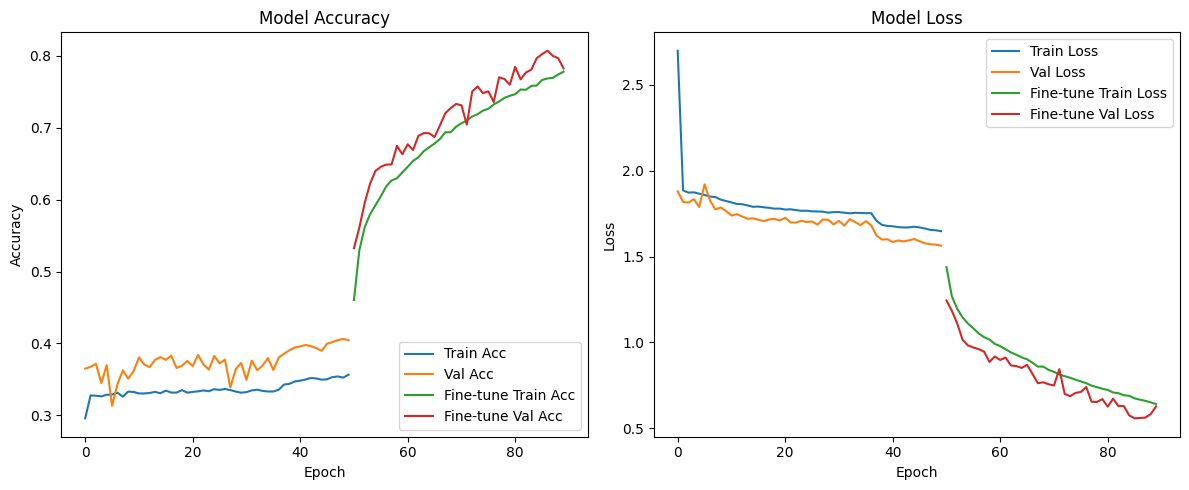

In [7]:
# Plot training history
def plot_training_history(history, history_finetune=None):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    if history_finetune:
        offset = len(history.history['accuracy'])
        plt.plot(range(offset, offset + len(history_finetune.history['accuracy'])),
                 history_finetune.history['accuracy'], label='Fine-tune Train Acc')
        plt.plot(range(offset, offset + len(history_finetune.history['val_accuracy'])),
                 history_finetune.history['val_accuracy'], label='Fine-tune Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    if history_finetune:
        offset = len(history.history['loss'])
        plt.plot(range(offset, offset + len(history_finetune.history['loss'])),
                 history_finetune.history['loss'], label='Fine-tune Train Loss')
        plt.plot(range(offset, offset + len(history_finetune.history['val_loss'])),
                 history_finetune.history['val_loss'], label='Fine-tune Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

plot_training_history(history, history_finetune)

446/446 [==============================] - 240s 536ms/step


<Figure size 800x600 with 0 Axes>

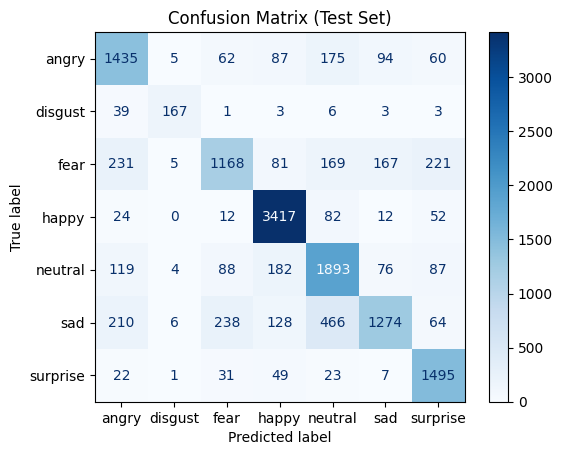

In [8]:
# Confusion Matrix on Test Data
def plot_confusion_matrix(model, generator):
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix (Test Set)')
    plt.show()

plot_confusion_matrix(model, test_generator)

In [11]:
# After training your model
model.save('best_mobilenet_fer_fine_v3.keras') # This saves in HDF5 format


446/446 [==============================] - 189s 423ms/step
F1 Score (macro): 0.7515927506680605


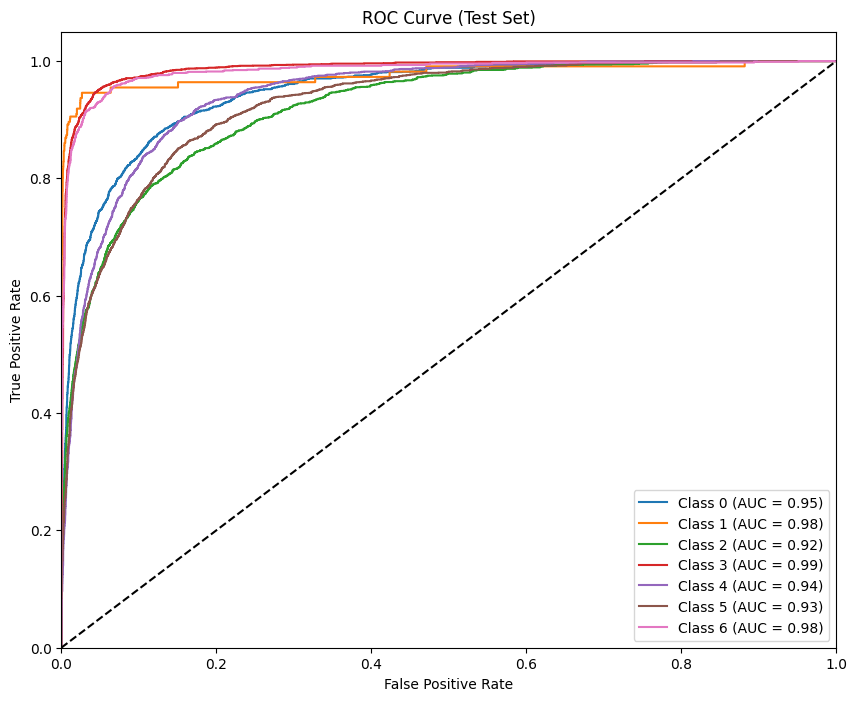

In [10]:
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# F1 Score
f1 = f1_score(y_true, y_pred, average='macro')
print('F1 Score (macro):', f1)

# ROC Curve
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Set)')
plt.legend(loc='lower right')
plt.show()


In [10]:
from sklearn.metrics import precision_score, recall_score
import numpy as np

class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
# y_true and y_pred should be integer-encoded (0=angry, 1=disgust, etc.)
# Example:
# y_true = [...]
# y_pred = [...]

all_class_indices = np.arange(len(class_labels))

precision_per_class = precision_score(y_true, y_pred, average=None, labels=all_class_indices, zero_division=0)
recall_per_class = recall_score(y_true, y_pred, average=None, labels=all_class_indices, zero_division=0)

for idx, label in enumerate(class_labels):
    print(f'Class {label}: Precision={precision_per_class[idx]:.4f}, Recall={recall_per_class[idx]:.4f}')


Class angry: Precision=0.5000, Recall=0.5000
Class disgust: Precision=0.0000, Recall=0.0000
Class fear: Precision=1.0000, Recall=1.0000
Class happy: Precision=0.0000, Recall=0.0000
Class neutral: Precision=0.0000, Recall=0.0000
Class sad: Precision=0.0000, Recall=0.0000
Class surprise: Precision=0.0000, Recall=0.0000


In [11]:
present_classes = np.unique(y_true)
for idx, class_idx in enumerate(present_classes):
    print(f'Class {class_labels[class_idx]}: Precision={precision_per_class[idx]:.4f}, Recall={recall_per_class[idx]:.4f}')


Class angry: Precision=0.5000, Recall=0.5000
Class disgust: Precision=0.0000, Recall=0.0000
Class fear: Precision=1.0000, Recall=1.0000


In [12]:
import numpy as np

class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
unique, counts = np.unique(y_true, return_counts=True)
for idx, count in zip(unique, counts):
    print(f'Class {class_labels[idx]}: {count} samples')



Class angry: 2 samples
Class disgust: 1 samples
Class fear: 2 samples
